In [1]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tnrange, tqdm_notebook
from scipy import ndimage

In [2]:
torch.cuda.set_device(1)

In [3]:
PATH = './'
TRAIN = './airbus-ship-detection/train_v2/'
TEST = './airbus-ship-detection/test_v2/'
SEGMENTATION = './airbus-ship-detection/train_ship_segmentations_v2.csv'
PRETRAINED_DETECTION_PATH = './airbus-ship-detection/fine-tuning-resnet34-on-ship-detection/models/'
PRETRAINED_SEGMENTATION_PATH = './models/'
DETECTION_TEST_PRED = './airbus-ship-detection/fine-tuning-resnet34-on-ship-detection/ship_detection.csv'

In [4]:
nw = 2   #number of workers for data loader
arch = resnet34 #specify target architecture

In [5]:
train_names = [f for f in os.listdir(TRAIN)]
test_names = [f for f in os.listdir(TEST)]
#5% of data in the validation set is sufficient for model evaluation
tr_n, val_n = train_test_split(train_names, test_size=0.05, random_state=42)
segmentation_df = pd.read_csv(os.path.join(PATH, SEGMENTATION)).set_index('ImageId')

In [6]:
def cut_empty(names):
    return [name for name in names 
            if(type(segmentation_df.loc[name]['EncodedPixels']) != float)]

tr_n_cut = cut_empty(tr_n)
val_n_cut = cut_empty(val_n)

In [7]:
def get_mask(img_id, df):
    shape = (768,768)
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    masks = df.loc[img_id]['EncodedPixels']
    if(type(masks) == float): return img.reshape(shape)
    if(type(masks) == str): masks = [masks]
    for mask in masks:
        s = mask.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1
    return img.reshape(shape).T

In [8]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.segmentation_df = pd.read_csv(SEGMENTATION).set_index('ImageId')
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_image(os.path.join(self.path, self.fnames[i]))
        if self.sz == 768: return img 
        else: return cv2.resize(img, (self.sz, self.sz))
    
    def get_y(self, i):
        mask = np.zeros((768,768), dtype=np.uint8) if (self.path == TEST) \
            else get_mask(self.fnames[i], self.segmentation_df)
        img = Image.fromarray(mask).resize((self.sz, self.sz)).convert('RGB')
        return np.array(img).astype(np.float32)
    
    def get_c(self): return 0

In [9]:
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
    tr_names = tr_n if (len(tr_n_cut)%bs == 0) else tr_n[:-(len(tr_n_cut)%bs)] #cut incomplete batch
    ds = ImageData.get_ds(pdFilesDataset, (tr_names,TRAIN), 
                (val_n_cut,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [10]:
cut,lr_cut = model_meta[arch]

In [11]:
def get_base(pre=True):              #load ResNet34 model
    layers = cut_model(arch(pre), cut)
    return nn.Sequential(*layers)

In [12]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()
    
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()
            
class UnetModel():
    def __init__(self,model,name='Unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [13]:
def IoU(pred, targs):
    pred = (pred > 0.5).astype(float)
    intersection = (pred*targs).sum()
    return intersection / ((pred+targs).sum() - intersection + 1.0)

In [14]:
def get_score(pred, true):
    n_th = 10
    b = 4
    thresholds = [0.5 + 0.05*i for i in range(n_th)]
    n_masks = len(true)
    n_pred = len(pred)
    ious = []
    score = 0
    for mask in true:
        buf = []
        for p in pred: buf.append(IoU(p,mask))
        ious.append(buf)
    for t in thresholds:   
        tp, fp, fn = 0, 0, 0
        for i in range(n_masks):
            match = False
            for j in range(n_pred):
                if ious[i][j] > t: match = True
            if not match: fn += 1
        
        for j in range(n_pred):
            match = False
            for i in range(n_masks):
                if ious[i][j] > t: match = True
            if match: tp += 1
            else: fp += 1
        score += ((b+1)*tp)/((b+1)*tp + b*fn + fp)       
    return score/n_th

In [15]:
def split_mask(mask):
    threshold = 0.5
    threshold_obj = 30 #ignor predictions composed of "threshold_obj" pixels or less
    labled,n_objs = ndimage.label(mask > threshold)
    result = []
    for i in range(n_objs):
        obj = (labled == i + 1).astype(int)
        if(obj.sum() > threshold_obj): result.append(obj)
    return result

In [16]:
def get_mask_ind(img_id, df, shape = (768,768)): #return mask for each ship
    masks = df.loc[img_id]['EncodedPixels']
    if(type(masks) == float): return []
    if(type(masks) == str): masks = [masks]
    result = []
    for mask in masks:
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        s = mask.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1
        result.append(img.reshape(shape).T)
    return result

In [17]:
class Score_eval():
    def __init__(self):
        self.segmentation_df = pd.read_csv(SEGMENTATION).set_index('ImageId')
        self.score, self.count = 0.0, 0
        
    def put(self,pred,name):
        true = get_mask_ind(name, self.segmentation_df)
        self.score += get_score(pred,true)
        self.count += 1
        
    def evaluate(self):
        return self.score/self.count

In [18]:
def aug_unit(x,fwd=True,mask=False):
    return x

def aug_flipV(x,fwd=True,mask=False):
    return x.flip(2) if mask else x.flip(3)

def aug_flipH(x,fwd=True,mask=False):
    return x.flip(1) if mask else x.flip(2)

def aug_T(x,fwd=True,mask=False):
    return torch.transpose(x,1,2) if mask else torch.transpose(x,2,3)

def aug_rot_2(x,fwd=True,mask=False): #rotate pi/2
    return aug_flipV(aug_flipH(x,fwd,mask),fwd,mask)

def aug_rot_4cr(x,fwd=True,mask=False): #rotate pi/4 counterclockwise
    return aug_flipV(aug_T(x,fwd,mask),fwd,mask) if fwd else \
        aug_T(aug_flipV(x,fwd,mask),fwd,mask)

def aug_rot_4cw(x,fwd=True,mask=False): #rotate pi/4 clockwise
    return aug_flipH(aug_T(x,fwd,mask),fwd,mask) if fwd else \
        aug_T(aug_flipH(x,fwd,mask),fwd,mask)

def aug_rot_2T(x,fwd=True,mask=False): #transpose and rotate pi/2
    return aug_rot_2(aug_T(x,fwd,mask),fwd,mask)

trms_side_on = [aug_unit,aug_flipH]
trms_top_down = [aug_unit,aug_flipV]
trms_dihedral = [aug_unit,aug_flipH,aug_flipV,aug_T,aug_rot_2,aug_rot_2T,
                 aug_rot_4cw,aug_rot_4cr]

In [34]:
trms_dihedral

[<function __main__.aug_unit(x, fwd=True, mask=False)>,
 <function __main__.aug_flipH(x, fwd=True, mask=False)>,
 <function __main__.aug_flipV(x, fwd=True, mask=False)>,
 <function __main__.aug_T(x, fwd=True, mask=False)>,
 <function __main__.aug_rot_2(x, fwd=True, mask=False)>,
 <function __main__.aug_rot_2T(x, fwd=True, mask=False)>,
 <function __main__.aug_rot_4cw(x, fwd=True, mask=False)>,
 <function __main__.aug_rot_4cr(x, fwd=True, mask=False)>]

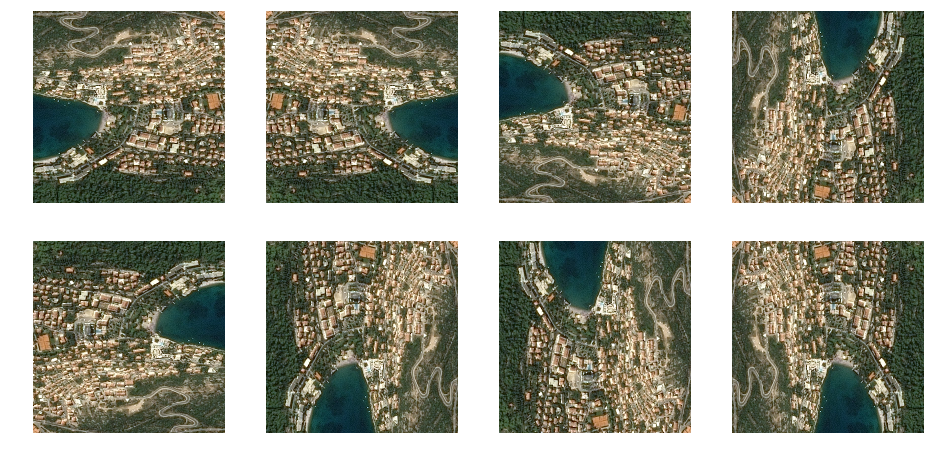

In [19]:
def enc_img(img):
    return torch.transpose(torch.tensor(img),0,2).unsqueeze(0)

def dec_img(img):
    return to_np(torch.transpose(img.squeeze(0),0,2))

def display_augs(x,augs=aug_unit):
    columns = 4
    n = len(augs)
    rows = n//4 + 1
    fig=plt.figure(figsize=(columns*4, rows*4))
    img = enc_img(x)
    for i in range(rows):
        for j in range(columns):
            idx = j+i*columns
            if idx >= n: break
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow(dec_img(augs[idx](img)))
    plt.show()
    
img = np.array(Image.open(os.path.join(TRAIN,'ce69faa4b.jpg')))
display_augs(img,trms_dihedral)

In [20]:
def model_pred(learner, dl, F_save): #if use train dl, disable shuffling
    learner.model.eval();
    name_list = dl.dataset.fnames
    num_batchs = len(dl)
    t = tqdm(iter(dl), leave=False, total=num_batchs)
    count = 0
    for x,y in t:
        py = to_np(torch.sigmoid(learn.model(V(x))))
        batch_size = len(py)
        for i in range(batch_size):
            F_save(py[i],to_np(y[i]),name_list[count])
            count += 1
            
def pred_aug(x,aug=[aug_unit]):
    pred = []
    for aug_cur in aug:
        py = to_np(aug_cur(torch.sigmoid(learn.model(V(aug_cur(x)))),
                           fwd=False, mask=True))
        pred.append(py)
    pred = np.stack(pred, axis=0).mean(axis=0)
    return pred

#if use train dl, disable shuffling
def model_pred_aug(learner, dl, F_save, aug=[aug_unit]):
    learner.model.eval();
    name_list = dl.dataset.fnames
    num_batchs = len(dl)
    t = tqdm(iter(dl), leave=False, total=num_batchs)
    count = 0
    for x,y in t:
        pred = pred_aug(x,aug)           
        batch_size = len(pred)
        for i in range(batch_size):
            F_save(pred[i],to_np(y[i]),name_list[count])
            count += 1

In [21]:
m = to_gpu(Unet34(get_base(False)))
models = UnetModel(m)

In [22]:
sz = 768 #image size
bs = 8  #batch size
md = get_data(sz,bs)

In [23]:
learn = ConvLearner(md, models)
learn.models_path = PRETRAINED_SEGMENTATION_PATH
learn.load('Unet34_768_1')
learn.models_path = PATH

In [24]:
score = Score_eval()
process_pred = lambda yp, y, name : score.put(split_mask(yp),name)
model_pred_aug(learn, md.val_dl, process_pred, trms_dihedral)
print('\n',score.evaluate())

                                                 
 0.38426941161281175


In [25]:
ship_detection = pd.read_csv(DETECTION_TEST_PRED)
ship_detection.head()

,id,p_ship
0,a0e433667.jpg,0.005674
1,ff0304b94.jpg,0.026962
2,1c1020bd2.jpg,0.002129
3,9a8446139.jpg,0.998240
4,9d6821cf6.jpg,0.000948


In [26]:
test_names = ship_detection.loc[ship_detection['p_ship'] > 0.5, ['id']]['id'].values.tolist()
test_names_nothing = ship_detection.loc[ship_detection['p_ship'] <= 0.5, ['id']]['id'].values.tolist()
len(test_names), len(test_names_nothing)

(3238, 12368)

In [27]:
md = get_data(sz,bs)
learn.set_data(md)

In [28]:
def decode_mask(mask, shape=(768, 768)):
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [29]:
ship_list_dict = []
for name in test_names_nothing:
    ship_list_dict.append({'ImageId':name,'EncodedPixels':np.nan})

In [30]:
def enc_test(yp, y, name):
    masks = split_mask(yp)
    if(len(masks) == 0): 
        ship_list_dict.append({'ImageId':name,'EncodedPixels':np.nan})
    for mask in masks:
        ship_list_dict.append({'ImageId':name,'EncodedPixels':decode_mask(mask)})

In [31]:
model_pred_aug(learn, md.test_dl, enc_test, trms_dihedral)
pred_df = pd.DataFrame(ship_list_dict)
pred_df.to_csv('submission.csv', index=False)